In [214]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import probplot
from scipy.stats import zscore

In [215]:
# Importing the dataset
df = pd.read_csv("water_dataX.csv", encoding= 'unicode_escape')
# Selecting 1900 samples, because samples having indices greater than 1900 are not correct
df = df.iloc[0:1900, :]
df.shape

(1900, 12)

In [216]:
# Checking for datatypes of the dataset
df.dtypes

STATION CODE                        object
LOCATIONS                           object
STATE                               object
Temp                                object
D.O. (mg/l)                         object
PH                                  object
CONDUCTIVITY (µmhos/cm)             object
B.O.D. (mg/l)                       object
NITRATENAN N+ NITRITENANN (mg/l)    object
FECAL COLIFORM (MPN/100ml)          object
TOTAL COLIFORM (MPN/100ml)Mean      object
year                                 int64
dtype: object

In [217]:
df.head()

,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203,NAN,0.1,11,27,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189,2,0.2,4953,8391,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179,1.7,0.1,3243,5330,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64,3.8,0.5,5382,8443,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83,1.9,0.4,3428,5500,2014


In [218]:
# Changing column names
df = df.rename(columns={"D.O. (mg/l)": "DO", "CONDUCTIVITY (µmhos/cm)": "Conductivity", "B.O.D. (mg/l)": "BOD", "NITRATENAN N+ NITRITENANN (mg/l)": "NI", "FECAL COLIFORM (MPN/100ml)": "Fec_col", "TOTAL COLIFORM (MPN/100ml)Mean": "Tot_col"})

In [219]:
# Converting object data type to numeric
def convert_to_numeric(df):
    num_col = df.shape[1]
    # Start from index 3
    for index in range(3, num_col):
        col_name = df.iloc[:, index].name
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
    return df

df = convert_to_numeric(df)
df.dtypes

STATION CODE     object
LOCATIONS        object
STATE            object
Temp            float64
DO              float64
PH              float64
Conductivity    float64
BOD             float64
NI              float64
Fec_col         float64
Tot_col         float64
year              int64
dtype: object

In [220]:
# Replacing string NAN values with actual NAN value (np.nan)
def convert_to_nan(df):
    n_col = df.shape[1]
    for index in range(n_col):
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

df = convert_to_nan(df)

In [221]:
# Checking for missing values
df.isnull().sum().sort_values()

year              0
PH                7
Conductivity     24
DO               30
BOD              42
Temp             89
STATION CODE    120
Tot_col         130
LOCATIONS       183
NI              189
Fec_col         280
STATE           670
dtype: int64

In [222]:
# Replacing NULL values with median of column
# Selecting numeric data
df_num = df.select_dtypes(exclude="object")
df_num_col = df_num.columns
imputer = SimpleImputer(strategy="mean")

df_num = imputer.fit_transform(df_num)
df_num = pd.DataFrame(df_num, columns=df_num_col)

In [223]:
# Filling Categorical missing values
df_cat = df.select_dtypes(include="object")
df_cat.isnull().sum()

STATION CODE    120
LOCATIONS       183
STATE           670
dtype: int64

In [224]:
# Here we can fill these values by obeserving other attributes
# Example - 
pd.set_option('mode.chained_assignment', None)
df_cat_copy = df_cat.copy()

df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]
# Station Code with value 1330 will have Location - TAMBIRAPARANI which belongs in STATE - TAMIL NADU
# I can replace all the NAN occurences in STATE with TAMILNADU
df_cat_copy["STATE"][df_cat_copy["STATION CODE"] == "1330"] = df_cat_copy["STATE"][df_cat_copy["STATION CODE"] == "1330"].fillna("TAMILNADU")

df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [225]:
# The NULL values in LOCATION attribute are in STATE attribute (ex - above dataframe)
# So, I will fill the NULL values in LOCATION attribute with the corresponding STATE value
# And, the state value will be replaced by the function "fill_state" defined below this cell

def fill_locations(df_cat):
    location_null = df_cat[df_cat["LOCATIONS"].isnull()]
    location_null_indices = location_null.index
    for index in location_null_indices:
        state_value = location_null["STATE"][index]
        location_null["LOCATIONS"][index] = state_value
        location_null["STATE"][index] = np.nan
    df_cat[df_cat["LOCATIONS"].isnull()] = location_null
    return

fill_locations(df_cat_copy)
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [226]:
df_cat_copy[df_cat_copy["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [227]:
# Now I can fill NULL values of Station code with corresponding LOCATION value(ex - above dataframe)
# I will match the corresponding LOCATION value with other same LOCATION value and insert the value of station code

def fill_code(df_cat):
    station_null = df_cat[df_cat["STATION CODE"].isnull()]
    station_null_indices = station_null.index
    for index in station_null_indices:
        stat_code = np.nan
        location_index = station_null["LOCATIONS"][index]
        code_at_location = df_cat["STATION CODE"][df_cat["LOCATIONS"] == location_index]
        for index_code in code_at_location.index:
            if (code_at_location[index_code] != np.nan):
                stat_code = code_at_location[index_code]
                break
        station_null["STATION CODE"][index] = stat_code
    df_cat[df_cat["STATION CODE"].isnull()] = station_null
    return

fill_code(df_cat_copy)
df_cat_copy[df_cat_copy["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [228]:
# Filling all state NAN values which have corresponding station code value
def fill_state(df_cat):
    station_code = df_cat["STATION CODE"].unique()
    for index in range(station_code.shape[0]):
        if (station_code[index] != np.nan):
            df_state = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] 
            state_values = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]]
            state = np.nan
            for index_state in range(state_values.shape[0]):
                if (state_values.iloc[index_state] != np.nan):
                    state = state_values.iloc[index_state]
                    break
            df_state_fill = df_state.fillna(state) 
            df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] = df_state_fill
    return
fill_state(df_cat_copy)
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [229]:
df_cat_copy.isnull().sum()

STATION CODE     4
LOCATIONS        2
STATE           12
dtype: int64

In [230]:
df_cat_copy[df_cat_copy["STATE"].isnull()]

,STATION CODE,LOCATIONS,STATE
260,NaN,NaN,NaN
431,NaN,NaN,NaN
1106,1207,KABBANI AT MUTHANKARA,NaN
1107,1208,BHAVANI AT ELACHIVAZHY,NaN
1650,2047,"NNANCHOE (ATTAWA CHOE), CHANDIGARH",NaN
1651,2048,"PATIALA KI RAO, CHANDIGARH",NaN
1652,2049,"SUKHNA CHOE, CHANDIGARH",NaN
1770,2047,NNANCHOE (ATTAWA CHOE),NaN
1771,2048,PATIALA KI RAO,NaN
1772,2049,SUKHNA CHOE,NaN


In [231]:
# The first location KABBANI AT MUTHANKARA is in STATE Kerela
df_cat_copy["STATE"][1106] = "KERALA"
df_cat_copy["STATE"][1107] = "KERALA"
df_cat_copy["STATE"][1650] = "CHANDIGARH"
df_cat_copy["STATE"][1651] = "CHANDIGARH"
df_cat_copy["STATE"][1652] = "CHANDIGARH"
df_cat_copy["STATE"][1770] = "CHANDIGARH"
df_cat_copy["STATE"][1771] = "CHANDIGARH"
df_cat_copy["STATE"][1772] = "CHANDIGARH"
df_cat_copy["STATE"][1784] = "DAMAN & DIU"
df_cat_copy["STATE"][1785] = "DAMAN & DIU"
df_cat_copy["STATION CODE"][1784] = "0000" # I am setting this according to myself
df_cat_copy["STATION CODE"][1785] = "0000"

In [232]:
df_cat = df_cat_copy
df_cat.isnull().sum()

STATION CODE    2
LOCATIONS       2
STATE           2
dtype: int64

In [233]:
df_num.isnull().sum()

Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

In [234]:
df_final = pd.concat([df_cat, df_num], axis=1)
df_final.isnull().sum()

STATION CODE    2
LOCATIONS       2
STATE           2
Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

In [235]:
# These are the samples which don't contain any attribute
# The filled attributes are median of corresponding columns
# So it is best to remove them
df_null = df_final[(df_final["STATION CODE"].isnull()) & (df_final["LOCATIONS"].isnull()) & (df_final["STATE"].isnull())]
df_null_indices = df_null.index
df_final.drop(df_null_indices, axis=0, inplace=True)
df_null

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
260,NaN,NaN,NaN,26.193505,6.354635,7.227912,1871.808225,6.857892,1.658681,374837.118364,560439.401695,2013.0
431,NaN,NaN,NaN,26.193505,6.354635,7.227912,1871.808225,6.857892,1.658681,374837.118364,560439.401695,2013.0


In [236]:
df_final.isnull().sum()

STATION CODE    0
LOCATIONS       0
STATE           0
Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

In [237]:
df_final.shape

(1898, 12)

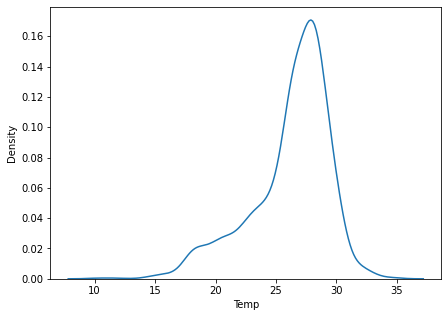

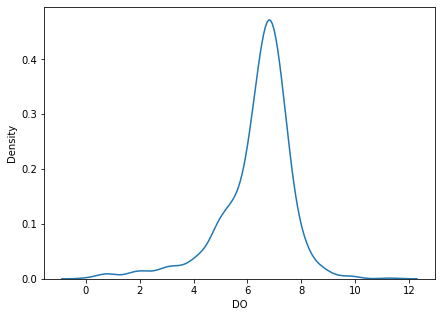

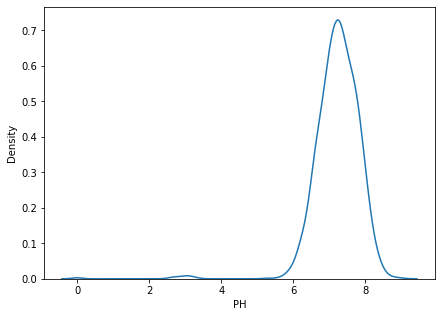

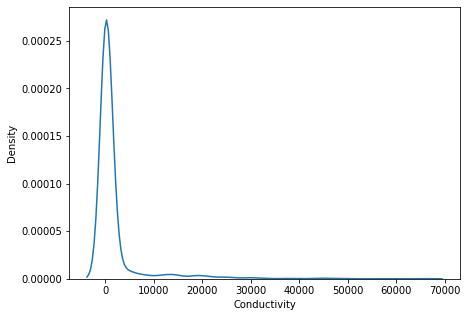

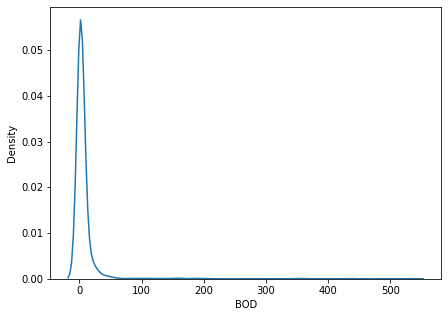

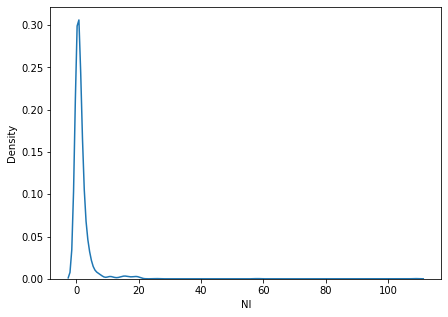

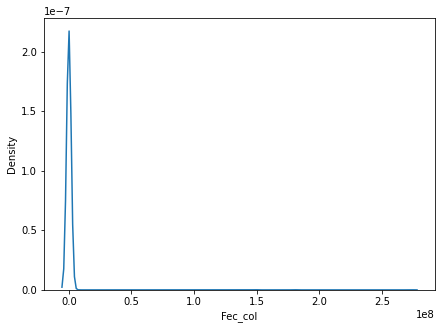

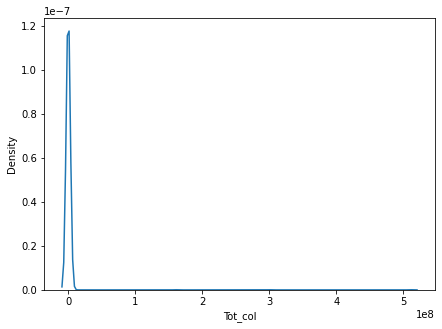

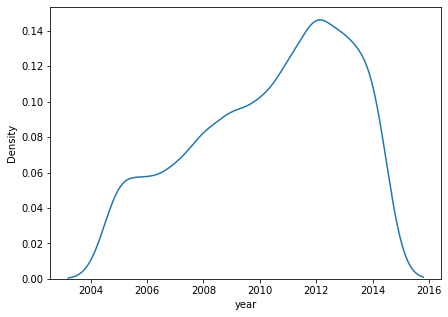

In [238]:
# PLotting PDFs of all the numeric attributes in the dataset

df_num_final = df_final.select_dtypes(exclude="object")

def plot_kde(df):
    n_col = df.shape[1]
    for index in range(n_col):
        col_index = df.iloc[:, index]
        fig, ax = plt.subplots(1,1, figsize=(7, 5))
        sns.kdeplot(data=df, x=col_index.name)
        
plot_kde(df_num_final)

In [239]:
# Ici, presque tous les plots kde sont gaussiens 
# Utilisation de la normalisation Z-Score pour détecter les valeurs aberrantes

df_num_final_norm = df_num_final.apply(zscore, axis=0)

def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[:, index]
        greater_than_3 = col_index[col_index > 3]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_num_final_norm)
print("Number of outliers using Z-Score method: ", len(indices_arr))
df_final.iloc[indices_arr, :]

Number of outliers using Z-Score method:  125


,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
741,2880,NAMBUL RIVER AT BISHNUPUR,MANIPUR,28.0,8.2,7.6,112.0,2.1,1.658681,3.748371e+05,31.0,2012.0
745,2856,"THOUBAL RIVER AT YAIRIPOK, THOUBAL",MANIPUR,30.0,9.3,7.6,193.0,2.3,1.658681,3.748371e+05,41.0,2012.0
37,2671,KUNDALIKA RIVER NEAR SALAV BRIDGE (SALINA ZONE...,MAHARASHTRA,25.3,5.3,7.7,24062.0,9.9,1.200000,1.560000e+02,304.0,2014.0
88,2294,R KALLAI AT KALLAI BRIDGE,KERALA,26.3,3.7,7.7,32005.0,1.2,0.900000,4.000000e+04,60392.0,2014.0
108,2304,R MOGRAL AT MOGRAL BR.,KERALA,30.0,5.6,7.2,24360.0,2.1,0.300000,9.200000e+01,447.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.000000,1.328000e+03,4975.0,2013.0
685,1023,GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA),PUNJAB,21.0,5.5,7.4,635.0,8.8,5.080000,1.400000e+03,5500.0,2012.0
172,3023,"VASISTA AT SALEM, D/S OF SAGO INDUSRIES EFFLUE...",TAMILNADU,24.3,0.9,7.6,2039.0,104.5,0.900000,2.725216e+08,511090873.0,2014.0
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.000000,1.328000e+03,4975.0,2013.0


In [240]:
df_final.drop(indices_arr, axis=0, inplace=True)
df_final.shape

(1785, 12)

In [241]:
# Calculating Water Quality Index of each sample
df_num_final = df_final.select_dtypes(exclude="object")
# Dropping year and Temp attribute because they are not used for computing WQI
df_num_final.drop(["year", "Temp"], axis=1, inplace=True)

# Weight Vector(wi)
wi = np.array([0.2213, 0.2604, 0.0022, 0.4426, 0.0492, 0.0221, 0.0022])

# Standard values of parameters(si)
si = np.array([10, 8.5, 1000, 5, 45, 100, 1000])

# Ideal values of paramters(vIdeal)
vIdeal = np.array([14.6, 7, 0, 0, 0, 0, 0])

def calc_wqi(sample): 
    wqi_sample = 0
    num_col = 7
    for index in range(num_col):
        v_index = sample[index] # Obeserved value of sample at index
        v_index_ideal = vIdeal[index] # Ideal value of obeserved value
        w_index = wi[index] # weight of corresponding parameter of obeserved value
        std_index = si[index] # Standard value recommended for obeserved value
        q_index = (v_index - v_index_ideal) / (std_index - v_index_ideal)
        q_index = q_index * 100 # Final qi value of obeserved value
        wqi_sample += q_index*w_index
    return wqi_sample

In [242]:
# Computing WQI for the whole dataset
def calc_wqi_for_df(df):
    wqi_arr = []
    for index in range(df.shape[0]):
        index_row = df.iloc[index, :]
        wqi_row = calc_wqi(index_row)
        wqi_arr.append(wqi_row)
    return wqi_arr

In [243]:
wqi_arr = calc_wqi_for_df(df_num_final)
# Converting oridnary array to numpy array
wqi_arr = np.array(wqi_arr)
wqi_arr = np.reshape(wqi_arr, (-1, 1))

# Resetting index values of the dataframes
wqi_arr_df = pd.DataFrame(wqi_arr, columns=["WQI"]).reset_index()
df_final = df_final.reset_index()

In [244]:
# Combining dataframe of WQI and dataframe of attributes 
df_wqi = pd.concat([df_final, pd.DataFrame(wqi_arr, columns=["WQI"])], axis=1)
df_wqi.drop("index", axis=1, inplace=True)
df_wqi.shape

(1785, 13)

In [245]:
# These are samples with negative WQI
df_wqi[(df_wqi["WQI"] < 0)]

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI
196,3375,LUKHA RIVER AT MYNDIHATI (TRIBUTARY OF LUNAR),MEGHALAYA,20.500000,6.700000,2.7,1350.0,3.300000,1.10,7.0,16.0,2014.0,-6.855044
234,1865,RIVER DHADAR AT KOTHADA,GUJARAT,26.193505,6.354635,0.0,506.0,6.857892,6.00,26.0,227.0,2013.0,-19.754707
446,3375,LUKHA RIVER,MEGHALAYA,21.300000,6.800000,2.7,1074.0,3.200000,2.33,4.0,11.0,2013.0,-8.214971
719,3375,LUKHA RIVER AT MYNDIHATI (TRIBUTARY OF LUNAR),MEGHALAYA,25.000000,6.900000,2.6,1072.0,3.200000,1.17,3.0,21.0,2012.0,-10.579224


In [246]:
# Removing the samples with negative WQI
df_neg_indices = df_wqi[(df_wqi["WQI"] < 0)].index
df_wqi.drop(df_neg_indices, axis=0, inplace=True)

In [247]:
df_wqi["WQI clf"] = df_wqi["WQI"].apply(lambda x: (3 if (0 <=x <= 25)
                                        else(3 if (26<=x<=50)
                                        else(2 if (51<=x<=75)
                                        else(1 if (76<=x<=100)
                                        else 0)))))

In [248]:
df_wqi.tail()

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI,WQI clf
1780,1329,"TAMBIRAPARANI AT RAIL BDG. NR. AMBASAMUDAM, TA...",TAMILNADU,27.000000,7.4,7.00,88.5,0.977,0.186000,27.0,105.0,2005.0,43.946271,3
1781,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU,26.193505,6.6,7.81,603.2,2.675,0.263000,40.0,191.0,2005.0,77.315135,1
1782,1450,"PALAR AT VANIYAMBADI WATER SUPPLY HEAD WORK, T...",TAMILNADU,28.000000,6.6,7.49,571.5,2.091,0.256000,151.0,273.0,2005.0,69.053768,2
1783,1403,"GUMTI AT U/S SOUTH TRIPURA,TRIPURA",TRIPURA,28.000000,5.4,7.16,75.8,2.092,1.658681,404.0,513.0,2005.0,74.795269,2
1784,1404,"GUMTI AT D/S SOUTH TRIPURA, TRIPURA",TRIPURA,30.000000,5.4,7.37,104.8,1.802,0.215000,456.0,557.0,2005.0,76.881207,1


In [249]:
n_unsuitable=(df_wqi['WQI clf']==0).sum()
n_very_poor=(df_wqi['WQI clf']==1).sum()
n_poor=(df_wqi['WQI clf']==2).sum()
n_good=(df_wqi['WQI clf']==3).sum()
n_excellent=(df_wqi['WQI clf']==4).sum()

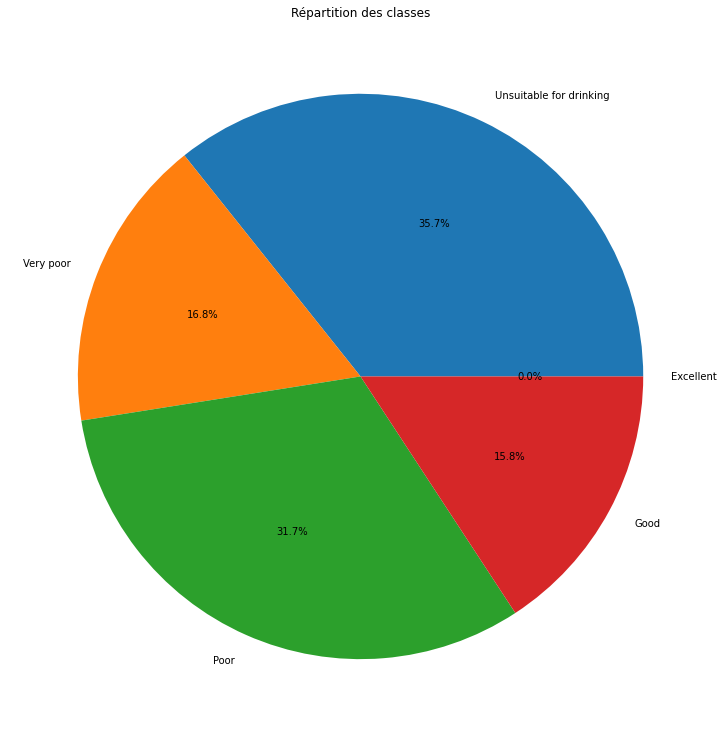

In [250]:
import matplotlib.pyplot as plt
# Définition des classes et de leurs effectifs
classes = ['Unsuitable for drinking', 'Very poor', 'Poor', 'Good', 'Excellent']
effectifs = [n_unsuitable,n_very_poor,n_poor,n_good,n_excellent]
# Création du diagramme circulaire
fig, ax = plt.subplots()
ax.pie(effectifs, labels=classes, autopct='%2.1f%%')
# Définir la taille de la figure
fig.set_size_inches(14, 13)
# Ajout d'un titre
ax.set_title('Répartition des classes')
# Affichage du diagramme
plt.show()


In [251]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten,Dropout
from tensorflow.keras.utils import to_categorical

# Charger les données
data = df_wqi

In [252]:
cols_to_drop=["STATION CODE","LOCATIONS","STATE","WQI","year","WQI clf"]

In [253]:
# Diviser les données en caractéristiques et cibles
X =  data.drop(cols_to_drop, axis=1)
y = data["WQI clf"].values

In [254]:
# Encoder les labels catégoriels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [255]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Balancing the data by SMOTE - Oversampling of Minority level\n')
smt = SMOTE()
counter = Counter(y)
print('Before SMOTE', counter)
X,y = smt.fit_resample(X,y)
counter = Counter(y)
print('\nAfter SMOTE', counter)

Balancing the data by SMOTE - Oversampling of Minority level

Before SMOTE Counter({0: 636, 2: 565, 1: 299, 3: 281})

After SMOTE Counter({0: 636, 1: 636, 2: 636, 3: 636})


In [256]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [257]:
# Redimensionner les données pour les convolutions 1D
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

In [258]:
# Convertir les labels en one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Créer le modèle CNN
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation="softmax"))

# Compiler le modèle
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [259]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_38 (Conv1D)          (None, 7, 32)             96        
                                                                 
 max_pooling1d_38 (MaxPoolin  (None, 7, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_39 (Conv1D)          (None, 6, 64)             4160      
                                                                 
 max_pooling1d_39 (MaxPoolin  (None, 6, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_40 (Conv1D)          (None, 5, 128)            16512     
                                                                 
 max_pooling1d_40 (MaxPoolin  (None, 5, 128)         

In [260]:
# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)
print(history.history['accuracy'])
print(history.history['loss'])

Epoch 1/100
64/64 [==============================] - 3s 18ms/step - loss: 43.9465 - accuracy: 0.3268 - val_loss: 5.2415 - val_accuracy: 0.3320
Epoch 2/100
64/64 [==============================] - 1s 14ms/step - loss: 7.0407 - accuracy: 0.3784 - val_loss: 1.9680 - val_accuracy: 0.3694
Epoch 3/100
64/64 [==============================] - 1s 19ms/step - loss: 2.9110 - accuracy: 0.4192 - val_loss: 1.6067 - val_accuracy: 0.3831
Epoch 4/100
64/64 [==============================] - 1s 21ms/step - loss: 1.8422 - accuracy: 0.4482 - val_loss: 1.1046 - val_accuracy: 0.4695
Epoch 5/100
64/64 [==============================] - 1s 16ms/step - loss: 1.5188 - accuracy: 0.5425 - val_loss: 1.2826 - val_accuracy: 0.4872
Epoch 6/100
64/64 [==============================] - 1s 13ms/step - loss: 1.2150 - accuracy: 0.5342 - val_loss: 1.0218 - val_accuracy: 0.5324
Epoch 7/100
64/64 [==============================] - 1s 15ms/step - loss: 1.0321 - accuracy: 0.5415 - val_loss: 0.9736 - val_accuracy: 0.5029
Epoch

In [261]:
# Évaluer le modèle sur les données de test
score = model.evaluate(X_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

16/16 [==============================] - 0s 7ms/step - loss: 0.4856 - accuracy: 0.8212
Test loss: 0.48559635877609253
Test accuracy: 0.8212180733680725


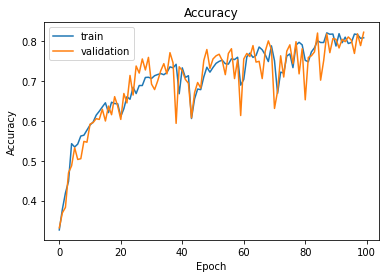

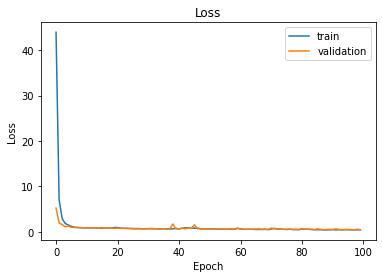

In [262]:

# Afficher les graphes d'accuracy et loss selon l'epoch
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [263]:
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
# Compute the confusion matrix for the test set
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print(confusion_matrix)


16/16 [==============================] - 0s 4ms/step
[[100  10   7   5]
 [  4 115  17   0]
 [  0  18 120   5]
 [  0   2  23  83]]


In [264]:
print(classification_report(y_true,y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.96      0.82      0.88       122
           1       0.79      0.85      0.82       136
           2       0.72      0.84      0.77       143
           3       0.89      0.77      0.83       108

    accuracy                           0.82       509
   macro avg       0.84      0.82      0.83       509
weighted avg       0.83      0.82      0.82       509

